# Applying SCRIPT Method with one minute time interval for new application

Developed by Siobhan Powell, 2021. 

In [1]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
s3_data_location = '' # fill in with data location

## Load charging data

In [2]:
df = pd.read_csv(s3_data_location+'sessions'+'2019'+'.csv', index_col=0)
df = df.loc[(df['POI Category']=='Workplace')&(df['Max Power']==6.6)].copy(deep=True).reset_index(drop=True)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## Optimizations - Create Training Data

In [3]:
def end_times_and_load(start_times, energies, durations, rate):

    time_steps_per_hour = 60
    num_time_steps = 1440
    load = np.zeros((num_time_steps,))
    end_times = np.zeros(np.shape(start_times)).astype(int)

    lengths = (time_steps_per_hour * energies / rate).astype(int)
    extra_charges = energies - lengths * rate / time_steps_per_hour
    inds1 = np.where((start_times + lengths) > num_time_steps)[0]
    inds2 = np.delete(np.arange(0, np.shape(end_times)[0]), inds1)

    end_times[inds1] = (np.minimum(start_times[inds1].astype(int)+lengths[inds1]-num_time_steps, num_time_steps)).astype(int)
    end_times[inds2] = (start_times[inds2] + lengths[inds2]).astype(int)
    inds3 = np.where(end_times >= num_time_steps)[0]
    inds4 = np.delete(np.arange(0, np.shape(end_times)[0]), inds3)

    for i in range(len(inds1)):
        idx = int(inds1[i])
        load[np.arange(int(start_times[idx]), num_time_steps)] += rate * np.ones((num_time_steps - int(start_times[idx]),))
        load[np.arange(0, end_times[idx])] += rate * np.ones((end_times[idx],))
    for i in range(len(inds2)):
        idx = int(inds2[i])
        load[np.arange(int(start_times[idx]), end_times[idx])] += rate * np.ones((lengths[idx],))
    load[0] += np.sum(extra_charges[inds3] * time_steps_per_hour)
    for i in range(len(inds4)):
        load[end_times[int(inds4[i])]] += extra_charges[int(inds4[i])] * time_steps_per_hour
        
    true_end_times = np.zeros(np.shape(start_times)).astype(int)
    inds1 = np.where((start_times + durations) > num_time_steps)[0]
    inds2 = np.delete(np.arange(0, np.shape(end_times)[0]), inds1)
    true_end_times[inds1] = (np.minimum(start_times[inds1].astype(int)+durations[inds1]-num_time_steps, num_time_steps)).astype(int)
    true_end_times[inds2] = (start_times[inds2] + durations[inds2]).astype(int)

    return true_end_times, load

In [4]:
class LoadModel(object):
    def __init__(self, num_sessions=1, charge_rate=6.6):
        """This method initializes many of the input and output variables used."""

        self.uncontrolled_total_load = np.zeros((1, ))  # The aggregate uncontrolled load profile
        self.controlled_total_load = np.zeros((1, ))
        self.num_sessions = num_sessions  # The number of sessions / number of cars in the parking lot that day
        self.arrival_inds = np.zeros((num_sessions,))  # The arrival time of each session, expressed as an index between 0 and 95
        self.departure_inds = np.zeros((num_sessions,))  # The index of the departure time for each vehicle
        self.energies = np.zeros((num_sessions,))  # The energy delivered in each uncontrolled session
        self.charge_rate = charge_rate  # The charge rate allowed. The default is level 2, 6.6 kW
        
    def input_data(self, uncontrolled_load, start_inds, end_inds, energies):
        """Here the data about the uncontrolled load is provided and the data is preprocessed."""
        
        self.uncontrolled_total_load = uncontrolled_load
        self.arrival_inds = start_inds
        self.departure_inds = end_inds
        inds1 = np.where(self.departure_inds >= self.arrival_inds)[0]
        inds2 = np.where(self.departure_inds < self.arrival_inds)[0]
        session_length = np.zeros(np.shape(self.departure_inds))
        session_length[inds1] = self.departure_inds[inds1] - self.arrival_inds[inds1]
        session_length[inds2] = 1440 - self.arrival_inds[inds2] + self.departure_inds[inds2]
        energies_true = np.minimum(energies, (1/60)*self.charge_rate*(session_length))
        self.energies = energies_true
#         print('Adjusted '+str(len(np.where(energies_true < (energies-0.1))[0]))+' energies')
        
    def minpeak_controlled_load(self, verbose=False):

        schedule = cvx.Variable((1440, self.num_sessions))
        obj = cvx.max(cvx.sum(schedule, axis=1))  # Minimize the peak total load reached at any time during the day
        constraints = [schedule >= 0, schedule <= 6.6]
        for i in range(self.num_sessions):
            if self.departure_inds[i] >= self.arrival_inds[i]:
                if self.arrival_inds[i] > 0:
                    constraints += [schedule[np.arange(0, int(self.arrival_inds[i])), i] <= 0]
                if self.departure_inds[i] < 1440:
                    constraints += [schedule[np.arange(int(self.departure_inds[i]), 1440), i] <= 0]
            else:
                constraints += [schedule[np.arange(int(self.departure_inds[i]), int(self.arrival_inds[i])), i] <= 0]
        constraints += [(1/60) * cvx.sum(schedule, axis=0) == self.energies]

        prob = cvx.Problem(cvx.Minimize(obj), constraints)
        result = prob.solve(solver=cvx.MOSEK)
        
        self.minpeak_controlled_power = schedule.value
        
    def minpeak_controlled_load_v2g(self, verbose=False):

        schedule = cvx.Variable((1440, self.num_sessions))
        net_energy = cvx.Variable((1440, self.num_sessions))
        obj = cvx.max(cvx.sum(schedule, axis=1))  # Minimize the peak total load reached at any time during the day
        constraints = [schedule >= -6.6, schedule <= 6.6, net_energy >= -5]

        for i in range(self.num_sessions):
            if self.departure_inds[i] == 1440:
                self.departure_inds[i] = 0
            constraints += [net_energy[self.arrival_inds[i], i] == 0]
            constraints += [net_energy[self.departure_inds[i], i] == self.energies[i]]
            constraints += [net_energy[:, i] <= (self.energies[i] + 5)]

            if self.departure_inds[i] >= self.arrival_inds[i]:
                constraints += [net_energy[np.arange(self.arrival_inds[i]+1, self.departure_inds[i]+1), i] == (net_energy[np.arange(self.arrival_inds[i], self.departure_inds[i]), i] + (1/60)*schedule[np.arange(self.arrival_inds[i], self.departure_inds[i]), i])]
                if self.arrival_inds[i] > 0:
                    constraints += [schedule[np.arange(0, int(self.arrival_inds[i])), i] == 0]
                if self.departure_inds[i] < 1440:
                    constraints += [schedule[np.arange(int(self.departure_inds[i]), 1440), i] == 0]
            else:
                constraints += [schedule[np.arange(int(self.departure_inds[i]), int(self.arrival_inds[i])), i] == 0]
                if self.departure_inds[i] > 0:
                    constraints += [net_energy[np.arange(1, self.departure_inds[i]+1), i] == (net_energy[np.arange(0, self.departure_inds[i]), i] + (1/60)*schedule[np.arange(0, self.departure_inds[i]), i])]
                if (self.arrival_inds[i]+1) < 1440:
                    constraints += [net_energy[np.arange(self.arrival_inds[i]+1, 1440), i] == (net_energy[np.arange(self.arrival_inds[i], 1440-1), i] + (1/60)*schedule[np.arange(self.arrival_inds[i], 1440-1), i])]
                constraints += [net_energy[0, i] == (net_energy[1440-1, i] + (1/60)*schedule[1440-1, i])]
        constraints += [(1/60) * cvx.sum(schedule, axis=0) == self.energies]

        prob = cvx.Problem(cvx.Minimize(obj), constraints)
        result = prob.solve(solver=cvx.MOSEK)
        
        self.minpeak_controlled_power = schedule.value
        
    def aef_controlled_load(self, energy_prices, verbose=False):
        """Minimize for average emissions intensity in the grid, given here with proxy 'energy_prices'."""

        schedule = cvx.Variable((1440, self.num_sessions))
        obj = cvx.matmul(cvx.sum(schedule, axis=1), energy_prices.reshape((np.shape(energy_prices)[0], 1)))
        
        constraints = [schedule >= 0, schedule <= 6.6]
        for i in range(self.num_sessions):
            if self.departure_inds[i] >= self.arrival_inds[i]:
                if self.arrival_inds[i] > 0:
                    constraints += [schedule[np.arange(0, int(self.arrival_inds[i])), i] <= 0]
                if self.departure_inds[i] < 1440:
                    constraints += [schedule[np.arange(int(self.departure_inds[i]), 1440), i] <= 0]
            else:
                constraints += [schedule[np.arange(int(self.departure_inds[i]), int(self.arrival_inds[i])), i] <= 0]
        constraints += [(1/60) * cvx.sum(schedule, axis=0) == self.energies]
        prob = cvx.Problem(cvx.Minimize(obj + 0.0001*cvx.sum_squares(cvx.sum(schedule, axis=1)[:-1] - cvx.sum(schedule, axis=1)[1:])), constraints)
        result = prob.solve(solver=cvx.MOSEK)

        self.solar_controlled_power = schedule.value
        
    def aef_controlled_load_v2g(self, energy_prices, verbose=False):
        """Minimize for average emissions intensity in the grid, given here with proxy 'energy_prices'."""

        schedule = cvx.Variable((1440, self.num_sessions))
        net_energy = cvx.Variable((1440, self.num_sessions))
        obj = cvx.matmul(cvx.sum(schedule, axis=1), energy_prices.reshape((np.shape(energy_prices)[0], 1)))
        
        constraints = [schedule >= -6.6, schedule <= 6.6, net_energy >= -5]

        for i in range(self.num_sessions):
            if self.departure_inds[i] == 1440:
                self.departure_inds[i] = 0
            
            constraints += [net_energy[self.arrival_inds[i], i] == 0]
            constraints += [net_energy[self.departure_inds[i], i] == self.energies[i]]
            constraints += [net_energy[:, i] <= (self.energies[i] + 5)]

            if self.departure_inds[i] >= self.arrival_inds[i]:
                constraints += [net_energy[np.arange(self.arrival_inds[i]+1, self.departure_inds[i]+1), i] == (net_energy[np.arange(self.arrival_inds[i], self.departure_inds[i]), i] + (1/60)*schedule[np.arange(self.arrival_inds[i], self.departure_inds[i]), i])]
                if self.arrival_inds[i] > 0:
                    constraints += [schedule[np.arange(0, int(self.arrival_inds[i])), i] == 0]
                if self.departure_inds[i] < 1440:
                    constraints += [schedule[np.arange(int(self.departure_inds[i]), 1440), i] == 0]
            else:
                constraints += [schedule[np.arange(int(self.departure_inds[i]), int(self.arrival_inds[i])), i] == 0]
                if self.departure_inds[i] > 0:
                    constraints += [net_energy[np.arange(1, self.departure_inds[i]+1), i] == (net_energy[np.arange(0, self.departure_inds[i]), i] + (1/60)*schedule[np.arange(0, self.departure_inds[i]), i])]
                if (self.arrival_inds[i]+1) < 1440:
                    constraints += [net_energy[np.arange(self.arrival_inds[i]+1, 1440), i] == (net_energy[np.arange(self.arrival_inds[i], 1440-1), i] + (1/60)*schedule[np.arange(self.arrival_inds[i], 1440-1), i])]
                constraints += [net_energy[0, i] == (net_energy[1440-1, i] + (1/60)*schedule[1440-1, i])]
        constraints += [(1/60) * cvx.sum(schedule, axis=0) == self.energies]
        
        prob = cvx.Problem(cvx.Minimize(obj + 0.0001*cvx.sum_squares(cvx.sum(schedule, axis=1)[:-1] - cvx.sum(schedule, axis=1)[1:])), constraints)
        result = prob.solve(solver=cvx.MOSEK)

        self.solar_controlled_power = schedule.value


### Get Average Emissions Profile for Objective Function

In [9]:
dpdf = pd.read_csv('../../GridModel_GridImpact/Results/NoEVs_year2030_solar2.5x_wind2.5x_dpdf_20211119.csv')
avg_emissions = dpdf['co2_tot'].values / dpdf['total_incl_noncombustion'].values
ai_case2 = np.copy(np.repeat(np.median(avg_emissions.reshape(-1,24), axis=0), 60))

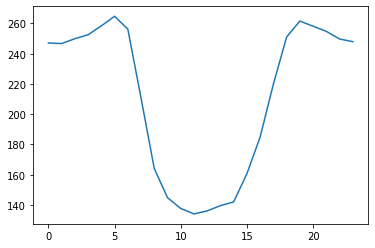

In [12]:
plt.plot(np.median(avg_emissions.reshape(-1,24), axis=0))

In [13]:
import cvxpy as cvx
import time

In [ ]:
num_runs = 1000
num_cars = 150
inds_all = np.zeros((num_runs, num_cars))
input_data = np.zeros((num_runs, 1440))
output_data_control1 = np.zeros((num_runs, 1440))
output_data_control2 = np.zeros((num_runs, 1440))
tic = time.time()
for i in range(num_runs):
# i = 0
    if np.mod(i, 100) == 0:
        toc = time.time()
        print('Done ', i, 'runs')
        print('Time since last mark: ', toc-tic)
        tic = time.time()
    inds = np.random.choice(range(df.shape[0]), num_cars)
    inds_all[i, :] = inds
    start_times = (df.loc[inds, 'start_seconds'].values/60).astype(int)
    durations = (df.loc[inds, 'Session Time (secs)'].values/60).astype(int)
    energies = np.minimum(df.loc[inds, 'Energy (kWh)'].values, (1/60)*6.6*durations)
    end_times, uncontrolled_load = end_times_and_load(start_times, energies, durations, 6.6)

    load = LoadModel(num_sessions=num_cars)
    load.input_data(uncontrolled_load, start_times, end_times, energies)
    input_data[i, :] = uncontrolled_load
    load.minpeak_controlled_load()
    output_data_control1[i, :] = np.sum(load.minpeak_controlled_power, axis=1)
    load.aef_controlled_load(ai_case2)
    output_data_control2[i, :] = np.sum(load.solar_controlled_power, axis=1)


In [17]:
np.save('control_input_data_uncontrolled_20211119.npy', input_data)
np.save('control_output_data_minpeak_20211119.npy', output_data_control1)
np.save('control_output_data_minavgemissions_20211119.npy', output_data_control2)
np.save('control_indices_20211119.npy', inds_all)


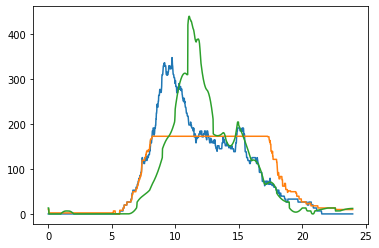

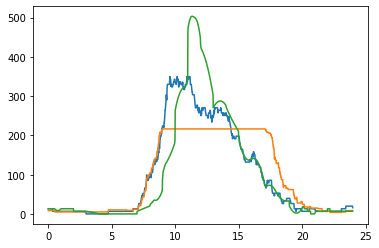

In [19]:
plt.figure()
plt.plot((1/60)*np.arange(0, 1440), input_data[0, :])
plt.plot((1/60)*np.arange(0, 1440), output_data_control1[0, :])
plt.plot((1/60)*np.arange(0, 1440), output_data_control2[0, :])
# plt.plot((1/60)*np.arange(0, 1440), output_data_control3[0, :])
plt.show()
plt.figure()
plt.plot((1/60)*np.arange(0, 1440), input_data[900, :])
plt.plot((1/60)*np.arange(0, 1440), output_data_control1[900, :])
plt.plot((1/60)*np.arange(0, 1440), output_data_control2[900, :])
# plt.plot((1/60)*np.arange(0, 1440), output_data_control3[900, :])
plt.show()

## Fit models

and report the results / error metric

In [20]:
from sklearn import metrics

In [21]:
from sklearn.preprocessing import normalize

In [22]:
import sklearn
from sklearn.preprocessing import normalize
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

In [23]:
def normalize_profiles(uncontrolled_profiles, controlled_profiles, return_norms=False):
    
    uncont_norm, norms_out = normalize(uncontrolled_profiles, norm='max', axis=1, return_norm=True)
    cont_norm = np.zeros(np.shape(controlled_profiles))
    for i in range(np.shape(controlled_profiles)[0]):
        cont_norm[i, :] = controlled_profiles[i, :] / norms_out[i]
        
    if return_norms:
        return uncont_norm, cont_norm, norms_out
    else:
        return uncont_norm, cont_norm

def max_absolute_error(y_true, y_pred):
    diff = np.abs(y_true - y_pred).max()
    return diff
score = metrics.make_scorer(max_absolute_error, greater_is_better=False)

def aggregate(uncontrolled_profiles, controlled_profiles, shuffle=False, k=10):
    
    if shuffle:
        length = np.shape(uncontrolled_profiles)[0]
        new_inds = np.random.choice(range(length), length, replace=False)
        uncontrolled_profiles = uncontrolled_profiles[new_inds, :]
        controlled_profiles = controlled_profiles[new_inds, :]

    new_uncontrolled_profiles = np.zeros((int(np.shape(uncontrolled_profiles)[0]/k), np.shape(uncontrolled_profiles)[1]))
    new_controlled_profiles = np.zeros((int(np.shape(uncontrolled_profiles)[0]/k), np.shape(uncontrolled_profiles)[1]))
    for i in range(int(np.shape(uncontrolled_profiles)[0]/k)):
        for j in range(k):
            new_uncontrolled_profiles[i, :] += uncontrolled_profiles[k*i + j, :]
            new_controlled_profiles[i, :] += controlled_profiles[k*i + j, :]
            
    return uncontrolled_profiles, controlled_profiles, new_uncontrolled_profiles, new_controlled_profiles

def agg_fit_test(uncontrolled_profiles, controlled_profiles, return_all=False, agg=False):
    
    if agg:
        uncontrolled_profiles, controlled_profiles, new_uncontrolled_profiles, new_controlled_profiles = aggregate(uncontrolled_profiles, 
                                                                                                                   controlled_profiles, shuffle=True, k=10)
    else:
        new_uncontrolled_profiles = np.copy(uncontrolled_profiles)
        new_controlled_profiles = np.copy(controlled_profiles)
    
    uncont_norm, cont_norm = normalize_profiles(new_uncontrolled_profiles, new_controlled_profiles)
    X_train, X_test, y_train, y_test = train_test_split(uncont_norm, cont_norm, test_size=0.2, random_state=42)
    X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=1/8, random_state=42)

    param_grid = {'alpha':np.linspace(0, 2, 50)}
    clf_grid = GridSearchCV(Ridge(), param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=5) 
    clf_grid.fit(X_train, y_train)
    new_clf = clf_grid.best_estimator_
#     new_clf = LinearRegression(fit_intercept=True)
    new_clf.fit(X_train, y_train)

    mean_error = metrics.mean_squared_error(y_dev, new_clf.predict(X_dev))
    max_error =  max_absolute_error(y_dev, new_clf.predict(X_dev))
    print('Mean squared error:', mean_error)
    print('Max abs error:', max_error)
    if return_all:
        return new_clf, X_train, X_dev, X_test, y_train, y_dev, y_test
    else:
        return new_clf

### Min(Peak) Model

In [24]:
y = np.copy(output_data_control1)
X = np.copy(input_data)

In [25]:
clf, X_train, X_dev, X_test, y_train, y_dev, y_test = agg_fit_test(X, y, return_all=True)

Mean squared error: 0.0004260903875835734
Max abs error: 0.20490932221284794


In [26]:
np.sqrt(0.0004260903875835734)

0.02064195697078098

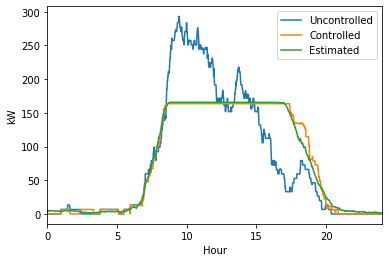

In [27]:
idx = 10

Xnorm, ynorm, norms = normalize_profiles(X, y, return_norms=True)
ypred_norm = clf.predict(Xnorm[idx, :].reshape(1, -1))
ypred = norms[idx] * ypred_norm
plt.figure()
plt.plot((1/60)*np.arange(0, 1440), X[idx, :])
plt.plot((1/60)*np.arange(0, 1440), y[idx, :])
plt.plot((1/60)*np.arange(0, 1440), ypred.ravel())
plt.legend(labels=['Uncontrolled', 'Controlled', 'Estimated'])
plt.ylabel('kW'); plt.xlabel('Hour'); plt.xlim([0, 24])
plt.show()

In [29]:
import pickle

In [30]:
pickle.dump(clf, open('workplace_control_model_1min_minpeak_20211119.p', "wb"))

### Min(Avg Em) Model

In [31]:
y = np.copy(output_data_control2)
X = np.copy(input_data)

clf, X_train, X_dev, X_test, y_train, y_dev, y_test = agg_fit_test(X, y, return_all=True)

Mean squared error: 0.0011227571274865752
Max abs error: 0.2587927767520708


In [32]:
np.sqrt(0.0011227571274865752)

0.033507568212070765

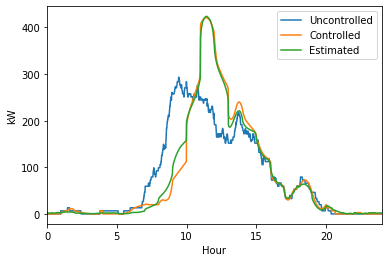

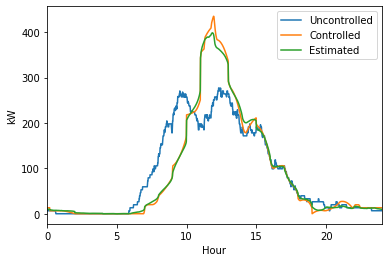

In [33]:
idx = 10

Xnorm, ynorm, norms = normalize_profiles(X, y, return_norms=True)
ypred_norm = clf.predict(Xnorm[idx, :].reshape(1, -1))
ypred = norms[idx] * ypred_norm
plt.figure()
plt.plot((1/60)*np.arange(0, 1440), X[idx, :])
plt.plot((1/60)*np.arange(0, 1440), y[idx, :])
plt.plot((1/60)*np.arange(0, 1440), ypred.ravel())
plt.legend(labels=['Uncontrolled', 'Controlled', 'Estimated'])
plt.ylabel('kW'); plt.xlabel('Hour'); plt.xlim([0, 24])
plt.show()

idx = 11

Xnorm, ynorm, norms = normalize_profiles(X, y, return_norms=True)
ypred_norm = clf.predict(Xnorm[idx, :].reshape(1, -1))
ypred = norms[idx] * ypred_norm
plt.figure()
plt.plot((1/60)*np.arange(0, 1440), X[idx, :])
plt.plot((1/60)*np.arange(0, 1440), y[idx, :])
plt.plot((1/60)*np.arange(0, 1440), ypred.ravel())
plt.legend(labels=['Uncontrolled', 'Controlled', 'Estimated'])
plt.ylabel('kW'); plt.xlabel('Hour'); plt.xlim([0, 24])
plt.show()

In [36]:
# pickle.dump(clf, open('workplace_control_model_1min_solar_20211119.p', "wb"))

In [37]:
pickle.dump(clf, open('workplace_control_model_1min_avgem_20211119.p', "wb"))